In [1]:
import pandas as pd
import os
import evaluate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tqdm
from collections import defaultdict
import matplotlib.font_manager as fm

[2025-04-22 19:58:40,164] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/developer/anaconda3/envs/report_gen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.1.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/home/developer/anaconda3/envs/report_gen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.1.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -lcufile
collect2: error: ld returned 1 exit status


In [2]:
def bootstrap_ci(scores, n_bootstrap=10000, confidence_level=95):
    n_samples = len(scores)
    bootstrap_means = []
    for _ in range(n_bootstrap):
        resampled_scores = np.random.choice(scores, size=n_samples, replace=True)
        bootstrap_means.append(np.mean(resampled_scores))
    bootstrap_means = np.array(bootstrap_means)
    mean_score = np.mean(bootstrap_means)
    std_score = np.std(bootstrap_means)    
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    return mean_score, std_score, ci_lower, ci_upper

# Figure 3

In [3]:
MODELS = [
  "mistral",
  "llama",
  "qwen",
  "deepseek_llama",
  "deepseek_qwen",
  "biomistral",
  "meditron",
  "gpt4o",
  "gpt4o_mini",
  "claude3_5",
  "o1",
  "o1_mini",
  "referring_physician"
]

DISPLAY_NAMES = [
    'Mistral\nv0.3', 
    'Llama 3.1', 
    "Qwen 2.5",
    'DeepSeek\nLlama',
    'DeepSeek\nQwen',
    'BioMistral', 
    'Meditron3', 
    'GPT-4o', 
    'GPT-4o\nmini',
    "Claude 3.5\nSonnet",
    "o1",
    "o1 mini",
    "Referring Physician"
]

fig3_model_statistics = {}
for model in tqdm.tqdm(MODELS):
    model_scores = pd.read_csv(f"../analysis/llm_evaluation_scores/{model}.csv")
    summary_statistics = {}
    statistics = ["rouge", "medcon", "radgraph", "bertscore"]
    for statistic in statistics:
        summary_statistics[f'{statistic}_mean'],\
        summary_statistics[f'{statistic}_std'],\
        summary_statistics[f'{statistic}_ci_lower'],\
        summary_statistics[f'{statistic}_ci_upper'] = bootstrap_ci(
            np.array(model_scores[statistic].tolist()), 
            n_bootstrap=10000
        )
    fig3_model_statistics[model] = summary_statistics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


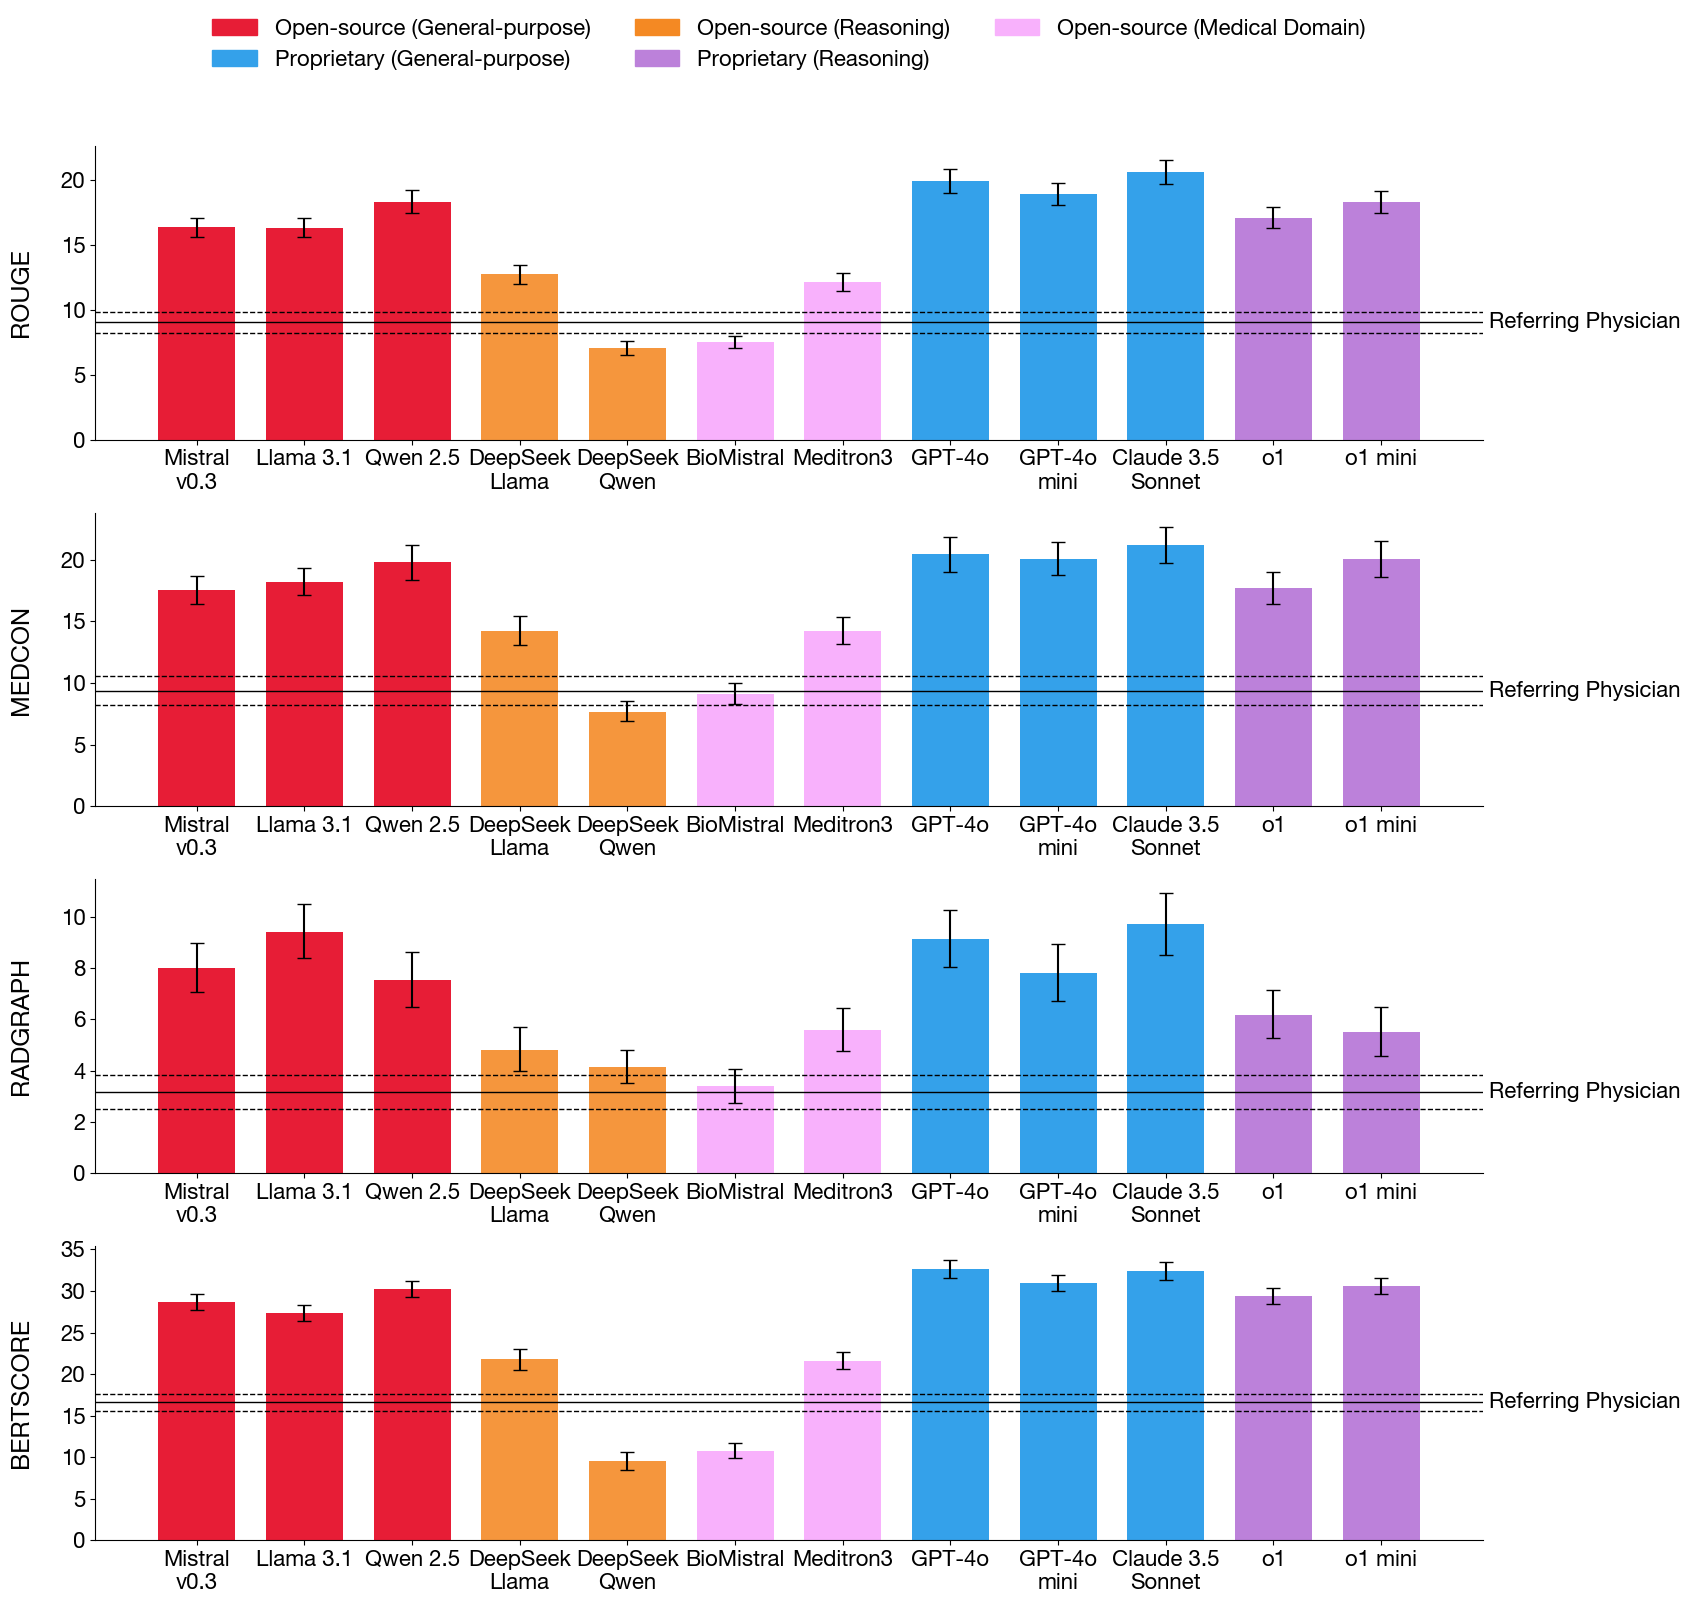

In [4]:
def fig3_plot_data(ax, metric, model_statistics, models, display_names, legend=False):
    score_means = []
    score_lower_errors = []
    score_upper_errors = []
    for model in models:
        if model != "referring_physician":
            stats = model_statistics[model]
            mean = stats[f'{metric}_mean']
            score_means.append(mean * 100) 
            lower_error = (mean - stats[f'{metric}_ci_lower']) * 100
            upper_error = (stats[f'{metric}_ci_upper'] - mean) * 100
            score_lower_errors.append(lower_error)
            score_upper_errors.append(upper_error)
    colors = [
        '#E71D36', 
        '#E71D36', 
        '#E71D36', 
        '#F5963D', 
        '#F5963D', 
        '#F8B1FC', 
        '#F8B1FC',
        "#34A1EA",
        '#34A1EA',
        '#34A1EA',
        '#BC81DA',
        '#BC81DA'
    ]

    x_positions = np.arange(len(display_names[:-1])) * 0.7  # Adjust the multiplier to control spacing

    bars = ax.bar(
        x_positions, 
        score_means, 
        yerr=[score_lower_errors, score_upper_errors], 
        capsize=5, 
        color=colors,
        width=0.5
    )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(display_names[:-1])

    path = 'HelveticaNeue.ttf'
    fontprop = fm.FontProperties(fname=path, size=18) 
    
    ax.set_ylabel(metric.upper(), labelpad=20, fontproperties=fontprop)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    referring_stats = fig3_model_statistics['referring_physician']
    ref_mean = referring_stats[f'{metric}_mean'] * 100
    ref_ci_lower = referring_stats[f'{metric}_ci_lower'] * 100
    ref_ci_upper = referring_stats[f'{metric}_ci_upper'] * 100

    path = 'HelveticaNeue.ttf'
    fontprop = fm.FontProperties(fname=path, size=16) 
    
    # Define x as an array
    xmin, xmax = -0.5, len(display_names) - 0.5
    x = np.linspace(xmin, xmax, 100)
    ax.axhline(y=ref_ci_lower, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=ref_mean, color='black', linestyle='-', linewidth=1, label='Referring Physician')
    ax.axhline(y=ref_ci_upper, color='black', linestyle='--', linewidth=1)
    ax.text((len(display_names) - 1)*0.7, ref_mean, 'Referring Physician', 
    color='black', va='center', ha='left', fontsize=16, fontproperties=fontprop)

    for label in ax.get_yticklabels():
        label.set_fontproperties(fontprop)
    for label in ax.get_xticklabels():
        label.set_fontproperties(fontprop)
    
    general_legend = mpatches.Patch(color='#E71D36', label='Open-source (General-purpose)')
    reasoning_legend = mpatches.Patch(color='#F48923', label='Open-source (Reasoning)')
    medical_legend = mpatches.Patch(color='#F8B1FC', label='Open-source (Medical Domain)')
    proprietary_legend = mpatches.Patch(color='#34A1EA', label='Proprietary (General-purpose)')
    proprietary_reasoning_legend = mpatches.Patch(color='#BC81DA', label='Proprietary (Reasoning)')

    if legend:
        ax.legend(
            handles=[general_legend, proprietary_legend, reasoning_legend, proprietary_reasoning_legend, medical_legend], 
            prop=fontprop,
            loc='upper center', 
            ncols=3, 
            frameon=False, 
            bbox_to_anchor=(0.5, 1.5)
        )

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(17, 16))
fig3_plot_data(ax[0], "rouge", fig3_model_statistics, MODELS, DISPLAY_NAMES, legend=True)
fig3_plot_data(ax[1], "medcon", fig3_model_statistics, MODELS, DISPLAY_NAMES)
fig3_plot_data(ax[2], "radgraph", fig3_model_statistics, MODELS, DISPLAY_NAMES)
fig3_plot_data(ax[3], "bertscore", fig3_model_statistics, MODELS, DISPLAY_NAMES)

# fig.subplots_adjust(wspace=0.4, hspace=0.85, left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.tight_layout()
plt.savefig("fig3_automated_llm_evaluation_dataset.png", dpi=300)

# Supplemental Material 3

In [5]:
df = pd.DataFrame(fig3_model_statistics).T
formatted_df = pd.DataFrame()
metrics = ['rouge', 'medcon', 'radgraph', 'bertscore']
for metric in metrics:
    mean_row = (df[f"{metric}_mean"]*100).round(2)
    ci_lower_row = (df[f"{metric}_ci_lower"]*100).round(2)
    ci_upper_row = (df[f"{metric}_ci_upper"]*100).round(2)
    formatted_df[metric.upper()] = mean_row.astype(str) + " (" + ci_lower_row.astype(str) + ", " + ci_upper_row.astype(str) + ")"
formatted_df.to_csv("supplemental_material_3.csv")

# Supplemental Material 4

In [6]:
scores = pd.DataFrame(fig3_model_statistics).T[["rouge_mean", "medcon_mean", "radgraph_mean", "bertscore_mean"]]
metrics = ["rouge_mean", "medcon_mean", "radgraph_mean", "bertscore_mean"]
for m in metrics:
    column_name = m.upper().replace("_MEAN", " Rank")
    scores[column_name] = scores[m].rank(ascending=False)
scores["Average Rank"] = (
    scores["ROUGE Rank"] +
    scores["MEDCON Rank"] +
    scores["RADGRAPH Rank"] + 
    scores["BERTSCORE Rank"]
) / 4
scores = scores.sort_values("Average Rank")
scores = scores[["Average Rank", "ROUGE Rank", "MEDCON Rank", "RADGRAPH Rank", "BERTSCORE Rank"]]
scores.to_csv("supplemental_material_4.csv")

# Figure 4

In [7]:
BEST_OPEN_SOURCE = "qwen"
BEST_PROPRIETARY = "claude3_5"
REFERRING_PHYSICIAN = "referring_physician"
BODY_SYSTEMS = ["Head", "Neck", "Abdomen/Pelvis", "MSK", "Chest"]
PATHOPHYSIOLOGICAL_CATEGORIES = ["Cancer/Mass", "Symptom-based", "Surgical", "Infection/Inflammatory", "Structural"]
DISPLAY_NAMES = {
    BEST_OPEN_SOURCE: 'Best open-source LLM (Qwen 2.5-7B Instruct)',
    BEST_PROPRIETARY: 'Best proprietary LLM (Claude 3.5 Sonnet)',
    REFERRING_PHYSICIAN: 'Referring Physician'
}
DISPLAY_LABELS = {
    "body_system": ["Head", "Neck", "Abdomen/\nPelvis", "MSK", "Chest"],
    "pathophysiological_category": ["Cancer/\nMass", "Symptom-based", "Surgical", "Infection/\nInflammatory", "Structural"]
}
groupings = {
    "body_system": BODY_SYSTEMS,
    "pathophysiological_category": PATHOPHYSIOLOGICAL_CATEGORIES
}
fig4_model_statistics = defaultdict(dict)
models = [BEST_OPEN_SOURCE, BEST_PROPRIETARY, REFERRING_PHYSICIAN]

for model in models:
    print("Model:", model)
    df = pd.read_csv(f"../analysis/llm_evaluation_scores/{model}.csv")
    
    for grouping, labels in groupings.items():
        # Initialize dictionary to hold metrics for this grouping.
        metrics_data = {metric: {"scores": [], "ci_lower": [], "ci_upper": []} 
                        for metric in ["rouge", "medcon", "radgraph", "bertscore"]}
        
        for label in labels:
            group_df = df[df[grouping] == label]
            
            for metric in metrics_data.keys():
                # Compute the mean and confidence intervals.
                mean, _, ci_lower, ci_upper = bootstrap_ci(group_df[metric].to_numpy(), n_bootstrap=10000)
                metrics_data[metric]["scores"].append(mean * 100)
                metrics_data[metric]["ci_lower"].append((mean - ci_lower) * 100)
                metrics_data[metric]["ci_upper"].append((ci_upper - mean) * 100)
        
        fig4_model_statistics[model][grouping] = metrics_data

Model: qwen
Model: claude3_5
Model: referring_physician


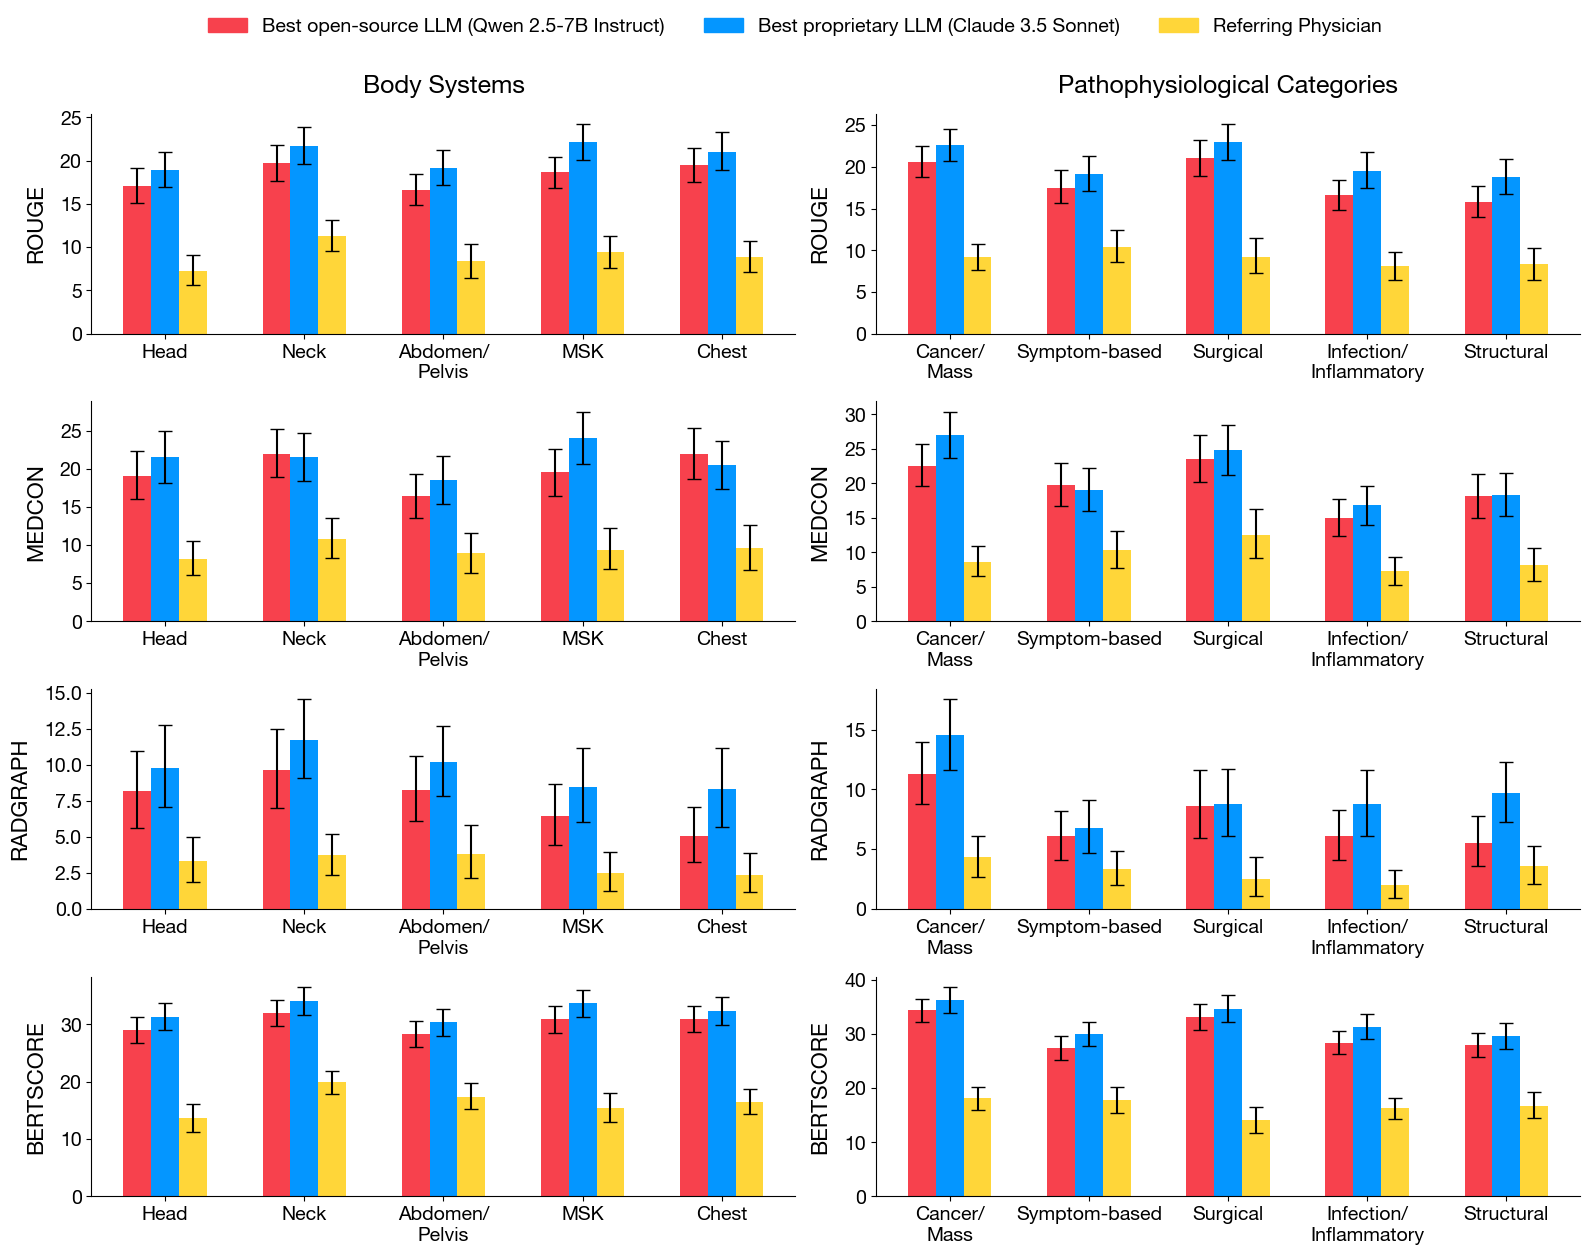

In [8]:
metrics = ["ROUGE", "MEDCON", "RADGRAPH", "BERTSCORE"]
bar_width = 0.2
colors = ['#F7414D', '#0496FF', '#FFD639']

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
grouping_titles = ["Body Systems", "Pathophysiological Categories"]

# Iterate over each metric (row) and each grouping (column)
for row, metric in enumerate(metrics):
    for col, (grouping, labels) in enumerate(DISPLAY_LABELS.items()):
        ax = axes[row, col]
        x = np.arange(len(labels))
        
        # For each model, plot its values with error bars.
        for idx, model in enumerate(models):
            key = metric.lower()  # e.g., "rouge"
            values = fig4_model_statistics[model][grouping][key][f"scores"]
            ci_lower = fig4_model_statistics[model][grouping][key][f"ci_lower"]
            ci_upper = fig4_model_statistics[model][grouping][key][f"ci_upper"]
            
            # Position bars: subtract bar_width for the first model, no shift for second, add for third.
            ax.bar(x + (idx - 1) * bar_width, values, bar_width,
                   yerr=[ci_lower, ci_upper], capsize=5,
                   label=DISPLAY_NAMES[model], color=colors[idx])

        path = 'HelveticaNeue.ttf'
        fontprop = fm.FontProperties(fname=path, size=16) 
        
        ax.set_ylabel(metric, fontproperties=fontprop, labelpad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        path = 'HelveticaNeue.ttf'
        fontprop = fm.FontProperties(fname=path, size=14) 

        for label in ax.get_xticklabels():
            label.set_fontproperties(fontprop) 
        for label in ax.get_yticklabels():
            label.set_fontproperties(fontprop) 
        
        if row == 0:
            path = 'HelveticaNeue.ttf'
            fontprop = fm.FontProperties(fname=path, size=18) 
            ax.set_title(grouping_titles[col], fontproperties=fontprop, pad=15)

legend_handles = [mpatches.Patch(color=colors[i], label=DISPLAY_NAMES[model]) 
                  for i, model in enumerate(models)]

path = 'HelveticaNeue.ttf'
fontprop = fm.FontProperties(fname=path, size=14) 

fig.legend(handles=legend_handles, loc='upper center', ncol=3, frameon=False, prop=fontprop, bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()
fig.savefig("fig4_best_automated_llm_evaluation_dataset.png", dpi=300, bbox_inches="tight")

# Supplemental Material 5

In [9]:
import pandas as pd

BEST_OPEN_SOURCE = "qwen"
BEST_PROPRIETARY = "claude3_5"
REFERRING_PHYSICIAN = "referring_physician"

models = {
    "Qwen": BEST_OPEN_SOURCE,
    "Claude": BEST_PROPRIETARY,
    "Referring Physician": REFERRING_PHYSICIAN
}

BODY_SYSTEMS = ["Head", "Neck", "Abdomen/Pelvis", "MSK", "Chest"]
PATHO_CATEGORIES = ["Cancer/Mass", "Symptom-based", "Surgical", "Infection/Inflammatory", "Structural"]

groupings = {
    "Body System": BODY_SYSTEMS,
    "Pathophysiological Category": PATHO_CATEGORIES
}

metrics = ["rouge", "medcon", "radgraph", "bertscore"]

all_data = []

for grouping_name, labels in groupings.items():
    for label in labels:
        row = {"Grouping": grouping_name, "Label": label}
        
        for model_name, model_file in models.items():
            df = pd.read_csv(f"../analysis/llm_evaluation_scores/{model_file}.csv")
            group_df = df[df[grouping_name.lower().replace(" ", "_")] == label]

            for metric in metrics:
                mean, _, ci_lower, ci_upper = bootstrap_ci(group_df[metric].to_numpy(), n_bootstrap=10000)
                mean *= 100
                ci_lower *= 100
                ci_upper *= 100
                formatted = f"{mean:.1f} ({ci_lower:.1f}, {ci_upper:.1f})"
                row[(metric, model_name)] = formatted
        
        all_data.append(row)

df_all_models = pd.DataFrame(all_data)
df_all_models = df_all_models.set_index(["Grouping", "Label"])
df_all_models.columns = pd.MultiIndex.from_tuples(df_all_models.columns)
df_all_models.to_csv("supplemental_material_5.csv")